In [19]:
import json
import numpy as np
from collections import defaultdict
import time

In [25]:
def load_data(json_file):
    """Load raw data from JSON file."""
    with open(json_file, 'r') as f:
        data = json.load(f)
    return [
        (sentence.split(), tags) 
        for sentence, tags in data
    ]

def split_data(sentences, test_ratio=0.2):
    """Split data into train/test sets."""
    np.random.seed(42)
    indices = np.random.permutation(len(sentences))
    split_idx = int(len(sentences) * (1 - test_ratio))
    return [sentences[i] for i in indices[:split_idx]], [sentences[i] for i in indices[split_idx:]]

def map_to_4tags(tag):
    """Collapse 36 tags into 4 categories."""
    if tag.startswith('N'): return 'N'
    elif tag.startswith('V'): return 'V'
    elif tag.startswith('JJ') or tag.startswith('RB'): return 'A'
    else: return 'O'

def preprocess_4tag(sentences):
    """Convert tags in sentences to 4 categories."""
    return [
        ([word.lower() for word in words], [map_to_4tags(tag) for tag in tags])
        for (words, tags) in sentences
    ]


In [26]:
def create_mappings(sentences):
    """Generate tag/word indices from training data."""
    all_tags, all_words = set(), set()
    for words, tags in sentences:
        all_tags.update(tags)
        all_words.update(words)
    tag2idx = {tag: i for i, tag in enumerate(all_tags)}
    word2idx = {word: i for i, word in enumerate(all_words)}
    idx2tag = {i: tag for tag, i in tag2idx.items()}
    return tag2idx, word2idx, idx2tag, all_tags, all_words


In [27]:
def train_model(train_data, tag2idx, word2idx):
    """Train HMM with numpy matrices (add-1 smoothing)."""
    num_tags = len(tag2idx)
    num_words = len(word2idx)
    
    # Initialize matrices
    transition = np.ones((num_tags, num_tags))
    initial = np.ones(num_tags)
    emission = np.ones((num_tags, num_words))
    
    for words, tags in train_data:
        prev_tag_idx = None
        for i, (word, tag) in enumerate(zip(words, tags)):
            word_idx = word2idx.get(word.lower(), -1)
            tag_idx = tag2idx[tag]
            
            if i == 0:
                initial[tag_idx] += 1
            else:
                transition[prev_tag_idx, tag_idx] += 1
            
            if word_idx != -1:
                emission[tag_idx, word_idx] += 1
            
            prev_tag_idx = tag_idx
    
    # Normalize probabilities
    initial = np.log(initial / initial.sum())
    transition = np.log(transition / transition.sum(axis=1, keepdims=True))
    emission = np.log(emission / emission.sum(axis=1, keepdims=True))
    
    return initial, transition, emission

In [28]:
def viterbi(sentence_words, initial, transition, emission, tag2idx, word2idx):
    """Fast Viterbi decoding with numpy."""
    n = len(sentence_words)
    num_tags = len(tag2idx)
    
    # Precompute word indices
    word_indices = [word2idx.get(word.lower(), -1) for word in sentence_words]
    
    # Initialize DP tables
    viterbi = np.zeros((n, num_tags)) + initial
    backpointers = np.zeros((n, num_tags), dtype=int)
    
    # First word
    if word_indices[0] != -1:
        viterbi[0] += emission[:, word_indices[0]]
    
    # Iterate
    for t in range(1, n):
        emit = emission[:, word_indices[t]] if word_indices[t] != -1 else 0
        scores = viterbi[t-1][:, None] + transition + emit
        viterbi[t] = np.max(scores, axis=0)
        backpointers[t] = np.argmax(scores, axis=0)
    
    # Backtrack
    best_path = [np.argmax(viterbi[-1])]
    for t in reversed(range(1, n)):
        best_path.insert(0, backpointers[t, best_path[0]])
    
    return best_path


In [ ]:
def get_top_probabilities(matrix, idx2tag, top_k=5, is_transition=False):
    """Extract top probabilities from numpy matrix."""
    results = {}
    for i in range(matrix.shape[0]):
        tag = idx2tag[i]
        probs = matrix[i]
        top_indices = np.argsort(probs)[-top_k:][::-1]
        results[tag] = [
            (idx2tag[j] if is_transition else j, np.exp(probs[j]))  # Fixed parenthesis
            for j in top_indices
        ]
    return results

def print_tag_probabilities(initial_probs, transition_probs, emission_probs, 
                           idx2tag, word2idx, top_k=5):
    """Print probabilities in readable format."""
    # Reverse word index for lookup
    idx2word = {v: k for k, v in word2idx.items()}
    
    print("\n=== Initial Probabilities ===")
    initial_exp = np.exp(initial_probs)
    for tag_idx in np.argsort(initial_exp)[::-1][:top_k]:
        print(f"{idx2tag[tag_idx]}: {initial_exp[tag_idx]:.4f}")
    
    print("\n=== Top Transition Probabilities ===")
    trans_top = get_top_probabilities(np.exp(transition_probs), idx2tag, top_k, True)
    for tag, probs in list(trans_top.items())[:3]:  # Print first 3 tags for brevity
        print(f"From {tag}:")
        for target_tag, prob in probs:
            print(f"  → {target_tag}: {prob:.4f}")
    
    print("\n=== Top Emission Probabilities ===")
    emit_top = get_top_probabilities(np.exp(emission_probs), idx2tag, top_k)
    for tag, probs in list(emit_top.items())[:3]:  # Print first 3 tags
        print(f"Tag {tag}:")
        for word_idx, prob in probs:
            word = idx2word.get(word_idx, "UNK")
            print(f"  - {word}: {prob:.4f}")



36-Tag Model Probabilities

=== Initial Probabilities ===
DT: 0.2448
NNP: 0.1981
IN: 0.1363
PRP: 0.0861
CC: 0.0536

=== Top Transition Probabilities ===
From IN:
  → DT: 1.3763
  → NNP: 1.1591
  → NN: 1.1171
  → JJ: 1.1039
  → CD: 1.0939
From UH:
  → IN: 1.0500
  → PRP: 1.0500
  → VBG: 1.0247
  → -RRB-: 1.0247
  → JJR: 1.0247
From VBZ:
  → VBN: 1.1858
  → DT: 1.1786
  → RB: 1.0983
  → IN: 1.0970
  → NNP: 1.0757

=== Top Emission Probabilities ===
Tag IN:
  - of: 1.0862
  - in: 1.0635
  - for: 1.0315
  - on: 1.0184
  - that: 1.0184
Tag UH:
  - ``no.'': 1.0001
  - ``mindful: 1.0001
  - Viacom's: 1.0001
  - reviewing: 1.0001
  - Force: 1.0001
Tag VBZ:
  - is: 1.0323
  - has: 1.0164
  - says: 1.0080
  - isn't: 1.0022
  - says.: 1.0019

4-Tag Model Probabilities

=== Initial Probabilities ===
O: 0.5764
N: 0.2957
A: 0.0986
V: 0.0293

=== Top Transition Probabilities ===
From N:
  → O: 1.5032
  → N: 1.4347
  → V: 1.1957
  → A: 1.0541
From O:
  → N: 1.4569
  → O: 1.3708
  → V: 1.1768
  → A: 1

In [29]:
sentences = load_data("penn-data.json")
train_36, test_36 = split_data(sentences)

# Preprocess for 4-tag
train_4 = preprocess_4tag(train_36)
test_4 = preprocess_4tag(test_36)

# ------------------- 36-Tag Configuration ------------------- #
print("Training 36-tag model...")
tag2idx_36, word2idx_36, idx2tag_36, _, _ = create_mappings(train_36)
initial_36, trans_36, emit_36 = train_model(train_36, tag2idx_36, word2idx_36)

# Predict
preds_36 = []
for words, _ in test_36:
    path = viterbi(words, initial_36, trans_36, emit_36, tag2idx_36, word2idx_36)
    preds_36.append([idx2tag_36[idx] for idx in path])

# Evaluate
correct_36 = sum(1 for (_, tags), pred in zip(test_36, preds_36) for t, p in zip(tags, pred) if t == p)
total_36 = sum(len(tags) for (_, tags) in test_36)
print(f"36-Tag Accuracy: {correct_36 / total_36:.4f}")

# ------------------- 4-Tag Configuration ------------------- #
print("\nTraining 4-tag model...")
tag2idx_4, word2idx_4, idx2tag_4, _, _ = create_mappings(train_4)
initial_4, trans_4, emit_4 = train_model(train_4, tag2idx_4, word2idx_4)

# Predict
preds_4 = []
for words, _ in test_4:
    path = viterbi(words, initial_4, trans_4, emit_4, tag2idx_4, word2idx_4)
    preds_4.append([idx2tag_4[idx] for idx in path])

# Evaluate
correct_4 = sum(1 for (_, tags), pred in zip(test_4, preds_4) for t, p in zip(tags, pred) if t == p)
total_4 = sum(len(tags) for (_, tags) in test_4)
print(f"4-Tag Accuracy: {correct_4 / total_4:.4f}")


Training 36-tag model...
36-Tag Accuracy: 0.7286

Training 4-tag model...
4-Tag Accuracy: 0.8818


In [32]:
print("\n" + "="*40)
print("36-Tag Model Probabilities")
print("="*40)
print_tag_probabilities(
    initial_36, 
    trans_36, 
    emit_36, 
    idx2tag_36, 
    word2idx_36
)

# ------------------- 4-Tag Probabilities ------------------- #
print("\n" + "="*40)
print("4-Tag Model Probabilities")
print("="*40)
print_tag_probabilities(
    initial_4, 
    trans_4, 
    emit_4, 
    idx2tag_4, 
    word2idx_4
)


36-Tag Model Probabilities

=== Initial Probabilities ===
DT: 0.2448
NNP: 0.1981
IN: 0.1363
PRP: 0.0861
CC: 0.0536

=== Top Transition Probabilities ===
From IN:
  → DT: 1.3763
  → NNP: 1.1591
  → NN: 1.1171
  → JJ: 1.1039
  → CD: 1.0939
From UH:
  → IN: 1.0500
  → PRP: 1.0500
  → VBG: 1.0247
  → -RRB-: 1.0247
  → JJR: 1.0247
From VBZ:
  → VBN: 1.1858
  → DT: 1.1786
  → RB: 1.0983
  → IN: 1.0970
  → NNP: 1.0757

=== Top Emission Probabilities ===
Tag IN:
  - of: 1.0862
  - in: 1.0635
  - for: 1.0315
  - on: 1.0184
  - that: 1.0184
Tag UH:
  - ``no.'': 1.0001
  - ``mindful: 1.0001
  - Viacom's: 1.0001
  - reviewing: 1.0001
  - Force: 1.0001
Tag VBZ:
  - is: 1.0323
  - has: 1.0164
  - says: 1.0080
  - isn't: 1.0022
  - says.: 1.0019

4-Tag Model Probabilities

=== Initial Probabilities ===
O: 0.5764
N: 0.2957
A: 0.0986
V: 0.0293

=== Top Transition Probabilities ===
From N:
  → O: 1.5032
  → N: 1.4347
  → V: 1.1957
  → A: 1.0541
From O:
  → N: 1.4569
  → O: 1.3708
  → V: 1.1768
  → A: 1

In [4]:
import numpy as np
import json
from collections import defaultdict, Counter

class HMMPOSTagger:
    def __init__(self, order=1):
        self.order = order
        self.tag_counts = Counter()
        self.word_tag_counts = defaultdict(Counter)
        self.transitions = defaultdict(Counter)
        self.unique_words = set()
        self.smoothing = 1e-5
        self.default_tag = None
    
    def train(self, sentences):
        for words, tags in sentences:
            prev_tags = tuple(['<s>'] * self.order)
            for word, tag in zip(words, tags):
                self.tag_counts[tag] += 1
                self.word_tag_counts[word][tag] += 1
                self.transitions[prev_tags][tag] += 1
                prev_tags = (prev_tags + (tag,))[-self.order:]
                self.unique_words.add(word)
        self.default_tag = max(self.tag_counts, key=self.tag_counts.get)
    
    def compute_probabilities(self):
        self.tag_totals = {tag: sum(self.transitions[prev].values()) for prev in self.transitions for tag in self.transitions[prev]}
        self.word_totals = {word: sum(self.word_tag_counts[word].values()) for word in self.word_tag_counts}
    
    def viterbi(self, sentence):
        n, states = len(sentence), list(self.tag_counts.keys())
        viterbi = np.full((len(states), n), -np.inf)
        backpointer = np.zeros((len(states), n), dtype=int)
        
        for i, tag in enumerate(states):
            viterbi[i, 0] = np.log((self.tag_counts[tag] + self.smoothing) / sum(self.tag_counts.values()))
        
        for t in range(1, n):
            for i, tag in enumerate(states):
                max_prob, best_prev = -np.inf, 0
                for j, prev_tag in enumerate(states):
                    trans_prob = np.log((self.transitions[(prev_tag,)][tag] + self.smoothing) / (self.tag_counts[prev_tag] + self.smoothing * len(states)))
                    word_prob = np.log((self.word_tag_counts[sentence[t]][tag] + self.smoothing) / (self.tag_counts[tag] + self.smoothing * len(self.unique_words)))
                    prob = viterbi[j, t-1] + trans_prob + word_prob
                    if prob > max_prob:
                        max_prob, best_prev = prob, j
                viterbi[i, t] = max_prob
                backpointer[i, t] = best_prev
        
        best_last = np.argmax(viterbi[:, -1])
        best_path = [states[best_last]]
        for t in range(n - 1, 0, -1):
            best_last = backpointer[best_last, t]
            best_path.insert(0, states[best_last])
        return best_path
    
    def evaluate(self, test_sentences):
        correct, total = 0, 0
        per_tag_correct, per_tag_total = Counter(), Counter()
        for words, true_tags in test_sentences:
            predicted_tags = self.viterbi(words)
            for true, pred in zip(true_tags, predicted_tags):
                if true == pred:
                    correct += 1
                    per_tag_correct[true] += 1
                per_tag_total[true] += 1
            total += len(words)
        accuracy = correct / total
        per_tag_accuracy = {tag: per_tag_correct[tag] / per_tag_total[tag] for tag in per_tag_total}
        return accuracy, per_tag_accuracy

# Load dataset
with open("penn-data.json", "r") as f:
    data = json.load(f)

# Split into train and test
split_idx = int(0.8 * len(data))
train_data, test_data = data[:split_idx], data[split_idx:]

# Train and evaluate model
tagger = HMMPOSTagger(order=1)
tagger.train(train_data)
tagger.compute_probabilities()
accuracy, per_tag_acc = tagger.evaluate(test_data)
print("Overall Accuracy:", accuracy)
print("Per-Tag Accuracy:", per_tag_acc)


Overall Accuracy: 0.017905138734850074
Per-Tag Accuracy: {'DT': 0.002482929857231533, 'JJS': 0.0, 'JJ': 0.0, 'NNS': 0.0, 'VBD': 0.0, 'VBN': 0.0, 'IN': 0.0025614754098360654, 'CD': 0.0009689922480620155, 'TO': 0.0, 'VB': 0.0, 'NN': 0.0028735632183908046, 'NNP': 0.9855555555555555, 'RB': 0.0, 'JJR': 0.0, 'NNPS': 0.0, 'RBS': 0.0, 'PRP$': 0.0, 'VBP': 0.0, 'CC': 0.0, 'VBZ': 0.0, 'VBG': 0.0, 'PRP': 0.0, 'MD': 0.0, 'RP': 0.0, 'EX': 0.0, 'WDT': 0.0, ':': 0.0, '#': 0.0, '-LRB-': 0.0, '-RRB-': 0.0, 'WP': 0.0, 'RBR': 0.0, 'WRB': 0.0, 'PDT': 0.0, "''": 0.0, 'WP$': 0.0}


In [ ]:
import json
import math
import random
from collections import defaultdict, Counter

# ----- Data Loading from JSON -----

def load_data_json(file_path):
    """
    Load data from a JSON file with the following format:
    [
      ["Sentence string", ["TAG1", "TAG2", ...]],
      ...
    ]
    Returns a list of sentences where each sentence is a list of (word, tag) tuples.
    Tokenizes the sentence by splitting on whitespace.
    """
    data = []
    with open(file_path, 'r') as f:
        json_data = json.load(f)
        for entry in json_data:
            sentence_str, tags = entry
            tokens = sentence_str.strip().split()
            if len(tokens) != len(tags):
                print("Warning: token count and tag count mismatch for sentence:", sentence_str)
                continue  # Skip sentences with mismatch
            data.append(list(zip(tokens, tags)))
    return data

def split_data(data, train_ratio=0.8):
    """
    Shuffle and split data into training and test sets.
    """
    random.shuffle(data)
    split_index = int(len(data) * train_ratio)
    return data[:split_index], data[split_index:]

# ----- Tag Collapsing for 4-Tag Configuration -----

def collapse_tag(tag):
    """
    Collapse a given tag into one of four categories:
      N -> noun tags (NN, NNS, NNP, NNPS)
      V -> verb tags (VB, VBD, VBG, VBN, VBP, VBZ)
      A -> adjectives and adverbs (JJ, JJR, JJS, RB, RBR, RBS, WRB)
      O -> all others
    """
    noun_tags = {'NN', 'NNS', 'NNP', 'NNPS'}
    verb_tags = {'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ'}
    adj_tags  = {'JJ', 'JJR', 'JJS'}
    adv_tags  = {'RB', 'RBR', 'RBS', 'WRB'}
    if tag in noun_tags:
        return "N"
    elif tag in verb_tags:
        return "V"
    elif tag in adj_tags or tag in adv_tags:
        return "A"
    else:
        return "O"

def collapse_data(data):
    """
    Given a dataset (list of sentences with (word, tag) tuples),
    return a new dataset where each tag is collapsed using collapse_tag.
    """
    collapsed = []
    for sentence in data:
        new_sentence = [(word, collapse_tag(tag)) for word, tag in sentence]
        collapsed.append(new_sentence)
    return collapsed

# ----- Training the HMM (Configuration C) with Smoothing -----
# Emission probability: P(word | tag, previous_word)
# Transition probability: P(curr_tag | prev_tag)
# We'll use add-one (Laplace) smoothing with a smoothing parameter alpha.

def train_hmm(train_data, alpha=0.5):
    """
    Train a first-order HMM with smoothing.
    Returns:
      - init_probs: smoothed initial probabilities P(tag as first tag)
      - trans_probs: smoothed transition probabilities P(curr_tag | prev_tag)
      - emission_probs: smoothed emission probabilities P(word | tag, previous_word)
      - vocab: set of observed words
      - default_tag: most frequent tag (used for unseen words)
    """
    init_counts = Counter()
    trans_counts = defaultdict(Counter)
    emission_counts = defaultdict(lambda: defaultdict(int))  # key: (tag, previous_word)
    tag_prev_counts = defaultdict(int)  # total count for each (tag, previous_word)
    tag_counts = Counter()
    vocab = set()

    for sentence in train_data:
        prev_word = "<s>"  # Special symbol for sentence start.
        if not sentence:
            continue
        first_word, first_tag = sentence[0]
        init_counts[first_tag] += 1
        tag_counts[first_tag] += 1
        vocab.add(first_word)
        # Emission for first word using "<s>" as previous word.
        emission_counts[(first_tag, prev_word)][first_word] += 1
        tag_prev_counts[(first_tag, prev_word)] += 1

        prev_tag = first_tag
        # Process the rest of the sentence.
        for i in range(1, len(sentence)):
            word, tag = sentence[i]
            vocab.add(word)
            trans_counts[prev_tag][tag] += 1
            tag_counts[tag] += 1
            prev_word = sentence[i-1][0]
            emission_counts[(tag, prev_word)][word] += 1
            tag_prev_counts[(tag, prev_word)] += 1
            prev_tag = tag

    num_sentences = len(train_data)
    states = list(tag_counts.keys())
    num_states = len(states)
    vocab_size = len(vocab)

    # Smoothing for initial probabilities.
    init_probs = {}
    for tag in states:
        init_probs[tag] = (init_counts.get(tag, 0) + alpha) / (num_sentences + alpha * num_states)

    # Smoothing for transition probabilities.
    trans_probs = {}
    for prev_tag in states:
        total = sum(trans_counts[prev_tag].values())
        trans_probs[prev_tag] = {}
        for curr_tag in states:
            count = trans_counts[prev_tag].get(curr_tag, 0)
            trans_probs[prev_tag][curr_tag] = (count + alpha) / (total + alpha * num_states)
    for tag in states:
        if tag not in trans_probs:
            trans_probs[tag] = {curr_tag: 1/num_states for curr_tag in states}

    # Smoothing for emission probabilities.
    emission_probs = {}
    for key in emission_counts:
        total = tag_prev_counts[key]
        emission_probs[key] = {}
        for word in vocab:
            count = emission_counts[key].get(word, 0)
            emission_probs[key][word] = (count + alpha) / (total + alpha * vocab_size)
    # For any (tag, prev_word) key not seen during training, no entry will be in emission_probs.

    default_tag = tag_counts.most_common(1)[0][0]
    return init_probs, trans_probs, emission_probs, vocab, default_tag

# ----- Viterbi Decoding -----

def viterbi(sentence, states, init_probs, trans_probs, emission_probs, vocab, default_tag):
    """
    Apply the Viterbi algorithm to find the best tag sequence for the given sentence.
    Uses emission probability: P(word | current_tag, previous_word).
    For the first word, previous word is "<s>".
    For unseen words, the default_tag is used (you can later extend this with an unknown-word model).
    """
    n = len(sentence)
    dp = [{} for _ in range(n)]          # dp[i][state]: best log-probability ending with 'state' at position i
    backpointer = [{} for _ in range(n)]
    
    # Initialization for the first word.
    first_word = sentence[0]
    prev_obs = "<s>"
    if first_word not in vocab:
        # For unseen first word, force default_tag.
        for state in states:
            if state == default_tag:
                dp[0][state] = math.log(init_probs.get(state, 1e-10))
            else:
                dp[0][state] = -float('inf')
            backpointer[0][state] = None
    else:
        for state in states:
            emis_prob = emission_probs.get((state, prev_obs), {}).get(first_word, 1e-10)
            dp[0][state] = math.log(init_probs.get(state, 1e-10)) + math.log(emis_prob)
            backpointer[0][state] = None

    # Recursion.
    for i in range(1, n):
        word = sentence[i]
        prev_obs = sentence[i-1]  # previous observed word
        if word not in vocab:
            # For unseen word, use a fallback approach: here we assign the default_tag a pseudo probability.
            for curr_state in states:
                if curr_state == default_tag:
                    best_prob = -float('inf')
                    best_prev = None
                    for prev_state in states:
                        trans_prob = trans_probs.get(prev_state, {}).get(curr_state, 1e-10)
                        prob = dp[i-1][prev_state] + math.log(trans_prob)
                        if prob > best_prob:
                            best_prob = prob
                            best_prev = prev_state
                    if best_prev is None:
                        best_prev = default_tag
                    dp[i][curr_state] = best_prob
                    backpointer[i][curr_state] = best_prev
                else:
                    dp[i][curr_state] = -float('inf')
                    backpointer[i][curr_state] = None
            continue

        for curr_state in states:
            emis_prob = emission_probs.get((curr_state, prev_obs), {}).get(word, 1e-10)
            best_prob = -float('inf')
            best_prev = None
            for prev_state in states:
                trans_prob = trans_probs.get(prev_state, {}).get(curr_state, 1e-10)
                prob = dp[i-1][prev_state] + math.log(trans_prob) + math.log(emis_prob)
                if prob > best_prob:
                    best_prob = prob
                    best_prev = prev_state
            if best_prev is None:
                best_prev = default_tag
            dp[i][curr_state] = best_prob
            backpointer[i][curr_state] = best_prev

    # Backtrace to recover the best path.
    best_last_state = max(dp[n-1], key=dp[n-1].get)
    best_path = [best_last_state]
    for i in range(n-1, 0, -1):
        prev_state = backpointer[i][best_path[0]]
        if prev_state is None:
            prev_state = default_tag
        best_path.insert(0, prev_state)
    
    return best_path

# ----- Evaluation Functions -----

def evaluate(test_data, states, init_probs, trans_probs, emission_probs, vocab, default_tag):
    """
    Evaluate the HMM tagger on test_data.
    Returns the overall tagging accuracy.
    """
    total_tags = 0
    correct_tags = 0
    for sentence in test_data:
        words = [word for word, tag in sentence]
        gold_tags = [tag for word, tag in sentence]
        pred_tags = viterbi(words, states, init_probs, trans_probs, emission_probs, vocab, default_tag)
        for gold, pred in zip(gold_tags, pred_tags):
            total_tags += 1
            if gold == pred:
                correct_tags += 1
    return correct_tags / total_tags if total_tags > 0 else 0

def per_tag_accuracy(test_data, states, init_probs, trans_probs, emission_probs, vocab, default_tag):
    """
    Compute per-tag accuracy.
    Returns a dictionary mapping each tag to its accuracy.
    """
    tag_correct = Counter()
    tag_total = Counter()
    
    for sentence in test_data:
        words = [word for word, tag in sentence]
        gold_tags = [tag for word, tag in sentence]
        pred_tags = viterbi(words, states, init_probs, trans_probs, emission_probs, vocab, default_tag)
        for gold, pred in zip(gold_tags, pred_tags):
            tag_total[gold] += 1
            if gold == pred:
                tag_correct[gold] += 1
                
    return { tag: tag_correct[tag] / tag_total[tag] for tag in tag_total }

# ----- Main Execution -----

if __name__ == "__main__":
    # Load the dataset from JSON.
    data = load_data_json("penn-data.json")
    print(f"Loaded {len(data)} sentences from the dataset.")

    # Split the data (80:20) for the 36-tag configuration.
    train_data_36, test_data_36 = split_data(data, train_ratio=0.8)
    print(f"36-Tag Model: {len(train_data_36)} training sentences, {len(test_data_36)} test sentences.")
    
    # Create collapsed (4-tag) versions for training and testing.
    train_data_4 = collapse_data(train_data_36)
    test_data_4 = collapse_data(test_data_36)
    print("4-Tag Model: Collapsed training and test data created.")

    # ------------------- 36-Tag Model -------------------
    # Train the HMM on the original 36-tag data.
    init_probs_36, trans_probs_36, emission_probs_36, vocab_36, default_tag_36 = train_hmm(train_data_36, alpha=0.5)
    states_36 = list({ tag for sentence in train_data_36 for _, tag in sentence })
    
    overall_acc_36 = evaluate(test_data_36, states_36, init_probs_36, trans_probs_36, emission_probs_36, vocab_36, default_tag_36)
    tag_acc_36 = per_tag_accuracy(test_data_36, states_36, init_probs_36, trans_probs_36, emission_probs_36, vocab_36, default_tag_36)
    
    print("\n--- 36-Tag Model Evaluation ---")
    print("Overall Accuracy:", overall_acc_36)
    print("Per-Tag Accuracy:")
    for tag, acc in sorted(tag_acc_36.items()):
        print(f"  {tag}: {acc:.2f}")

    # ------------------- 4-Tag Model -------------------
    # Train the HMM on the collapsed 4-tag data.
    init_probs_4, trans_probs_4, emission_probs_4, vocab_4, default_tag_4 = train_hmm(train_data_4, alpha=0.5)
    states_4 = list({ tag for sentence in train_data_4 for _, tag in sentence })
    
    overall_acc_4 = evaluate(test_data_4, states_4, init_probs_4, trans_probs_4, emission_probs_4, vocab_4, default_tag_4)
    tag_acc_4 = per_tag_accuracy(test_data_4, states_4, init_probs_4, trans_probs_4, emission_probs_4, vocab_4, default_tag_4)
    
    print("\n--- 4-Tag Model (Collapsed) Evaluation ---")
    print("Overall Accuracy:", overall_acc_4)
    print("Per-Tag Accuracy:")
    for tag, acc in sorted(tag_acc_4.items()):
        print(f"  {tag}: {acc:.2f}")


Loaded 3914 sentences from the dataset.
36-Tag Model: 3131 training sentences, 783 test sentences.
4-Tag Model: Collapsed training and test data created.

--- 36-Tag Model Evaluation ---
Overall Accuracy: 0.47781740817220447
Per-Tag Accuracy:
  #: 0.00
  -LRB-: 0.00
  -RRB-: 0.11
  :: 0.02
  CC: 0.22
  CD: 0.20
  DT: 0.76
  EX: 0.18
  IN: 0.77
  JJ: 0.40
  JJR: 0.01
  JJS: 0.06
  LS: 0.00
  MD: 0.39
  NN: 0.74
  NNP: 0.46
  NNPS: 0.19
  NNS: 0.20
  PDT: 0.00
  PRP: 0.46
  PRP$: 0.26
  RB: 0.08
  RBR: 0.00
  RBS: 0.14
  RP: 0.14
  SYM: 0.00
  TO: 0.49
  VB: 0.55
  VBD: 0.29
  VBG: 0.03
  VBN: 0.28
  VBP: 0.19
  VBZ: 0.23
  WDT: 0.07
  WP: 0.04
  WRB: 0.03


In [1]:
import json
import math
from collections import defaultdict, Counter

class HMMTagger:
    def __init__(self, smoothing=1e-8):
        # Transition counts: counts for (prev_tag -> curr_tag)
        self.transition_counts = defaultdict(Counter)
        # Emission counts: counts for (prev_tag, curr_tag, word)
        self.emission_counts = defaultdict(lambda: defaultdict(Counter))
        self.transition_probs = defaultdict(dict)
        self.emission_probs = defaultdict(lambda: defaultdict(dict))
        self.tags = set()
        self.vocab = set()
        self.smoothing = smoothing

    def train(self, tagged_sentences):
        """
        Train on a list of sentences, each a list of (word, tag) tuples.
        Emission probability is modeled as P(word | previous_tag, current_tag).
        """
        for sentence in tagged_sentences:
            prev_tag = "<s>"  # start-of-sentence symbol
            for word, tag in sentence:
                self.transition_counts[prev_tag][tag] += 1
                self.emission_counts[prev_tag][tag][word] += 1
                self.tags.add(tag)
                self.vocab.add(word)
                prev_tag = tag
            # Transition from the final tag to the end-of-sentence marker
            self.transition_counts[prev_tag]["</s>"] += 1

        # Compute transition probabilities P(Tᵢ | Tᵢ₋₁)
        for prev_tag, counter in self.transition_counts.items():
            total = sum(counter.values())
            for curr_tag, count in counter.items():
                self.transition_probs[prev_tag][curr_tag] = count / total

        # Compute emission probabilities P(word | previous_tag, current_tag)
        for prev_tag, tag_dict in self.emission_counts.items():
            for curr_tag, word_counter in tag_dict.items():
                total = sum(word_counter.values())
                for word, count in word_counter.items():
                    self.emission_probs[prev_tag][curr_tag][word] = count / total

    def viterbi(self, sentence):
        """
        Uses the Viterbi algorithm (with log probabilities) to find the best tag sequence for a sentence.
        """
        V = [{}]
        backpointer = [{}]

        # Initialization (assume start tag is <s>)
        for tag in self.tags:
            trans_prob = self.transition_probs.get("<s>", {}).get(tag, self.smoothing)
            emis_prob = self.emission_probs.get("<s>", {}).get(tag, {}).get(sentence[0], self.smoothing)
            V[0][tag] = math.log(trans_prob) + math.log(emis_prob)
            backpointer[0][tag] = "<s>"

        # Recursion
        for t in range(1, len(sentence)):
            V.append({})
            backpointer.append({})
            for curr_tag in self.tags:
                best_score = float("-inf")
                best_prev = None
                for prev_tag in self.tags:
                    prev_score = V[t-1][prev_tag]
                    trans_prob = self.transition_probs.get(prev_tag, {}).get(curr_tag, self.smoothing)
                    emis_prob = self.emission_probs.get(prev_tag, {}).get(curr_tag, {}).get(sentence[t], self.smoothing)
                    score = prev_score + math.log(trans_prob) + math.log(emis_prob)
                    if score > best_score:
                        best_score = score
                        best_prev = prev_tag
                V[t][curr_tag] = best_score
                backpointer[t][curr_tag] = best_prev

        # Termination (incorporate transition to end-of-sentence)
        best_score = float("-inf")
        best_final_tag = None
        t = len(sentence) - 1
        for tag in self.tags:
            term_prob = self.transition_probs.get(tag, {}).get("</s>", self.smoothing)
            score = V[t][tag] + math.log(term_prob)
            if score > best_score:
                best_score = score
                best_final_tag = tag

        # Backtrace the best tag path
        best_path = [best_final_tag]
        for t in range(len(sentence) - 1, 0, -1):
            best_path.insert(0, backpointer[t][best_path[0]])
        return best_path

def load_data(filename):
    """
    Load data from a JSON file.
    Each entry in the file should be a list: [sentence string, list of POS tags].
    The sentence is tokenized using whitespace.
    """
    with open(filename, 'r') as f:
        data = json.load(f)
    training_data = []
    for entry in data:
        sentence_str, tags = entry
        words = sentence_str.split()
        if len(words) != len(tags):
            print("Warning: Token-tag count mismatch in sentence:", sentence_str)
        training_data.append(list(zip(words, tags)))
    return training_data

def reduce_tags_data(tagged_sentences, mapping):
    """
    Convert each (word, tag) tuple in the data to use a reduced tag set.
    mapping: dictionary mapping original tags to the reduced set.
    """
    reduced_sentences = []
    for sentence in tagged_sentences:
        new_sentence = []
        for word, tag in sentence:
            new_tag = mapping.get(tag, tag)
            new_sentence.append((word, new_tag))
        reduced_sentences.append(new_sentence)
    return reduced_sentences

def evaluate_model_detailed(model, tagged_sentences):
    """
    Computes overall token accuracy and per-tag accuracies.
    Returns overall_accuracy and a dictionary mapping each tag to its accuracy.
    """
    total = 0
    correct = 0
    tag_total = defaultdict(int)
    tag_correct = defaultdict(int)
    
    for sentence in tagged_sentences:
        words = [word for word, tag in sentence]
        true_tags = [tag for word, tag in sentence]
        predicted_tags = model.viterbi(words)
        for pred, true in zip(predicted_tags, true_tags):
            total += 1
            tag_total[true] += 1
            if pred == true:
                correct += 1
                tag_correct[true] += 1
                
    overall_accuracy = correct / total if total > 0 else 0
    per_tag_accuracy = {tag: (tag_correct[tag] / tag_total[tag] if tag_total[tag] > 0 else 0)
                        for tag in tag_total}
    return overall_accuracy, per_tag_accuracy

if __name__ == "__main__":
    # Load the PTB data from JSON file
    data = load_data("penn-data.json")
    
    # --------------------------
    # 36-Tag Model
    # --------------------------
    hmm_36 = HMMTagger()
    hmm_36.train(data)
    overall_acc_36, per_tag_acc_36 = evaluate_model_detailed(hmm_36, data)
    
    # --------------------------
    # 4-Tag Reduced Model
    # --------------------------
    # Mapping from 36 tags to 4 coarse tags: N (noun), V (verb), ADJ (adjective), ADV (adverb)
    mapping = {
        # Nouns
        "NN": "N", "NNS": "N", "NNP": "N", "NNPS": "N",
        # Verbs
        "VB": "V", "VBD": "V", "VBG": "V", "VBN": "V", "VBP": "V", "VBZ": "V",
        # Adjectives
        "JJ": "ADJ", "JJR": "ADJ", "JJS": "ADJ",
        # Adverbs
        "RB": "ADV", "RBR": "ADV", "RBS": "ADV"
    }
    
    data_4 = reduce_tags_data(data, mapping)
    hmm_4 = HMMTagger()
    hmm_4.train(data_4)
    overall_acc_4, per_tag_acc_4 = evaluate_model_detailed(hmm_4, data_4)
    
    # The computed accuracies are now stored in:
    # overall_acc_36, per_tag_acc_36: for the 36-tag model
    # overall_acc_4, per_tag_acc_4: for the 4-tag reduced model
    # These can now be used for further processing or reporting.
    
    # For example, you can access:
    # overall_acc_36 -> overall accuracy for the 36-tag model
    # per_tag_acc_36 -> dictionary of accuracies for each tag (36-tag model)
    # overall_acc_4 -> overall accuracy for the 4-tag model
    # per_tag_acc_4 -> dictionary of accuracies for each tag (4-tag model)


In [9]:
import json
import math
import random
from collections import defaultdict, Counter

class HMMTagger:
    def __init__(self, smoothing=1e-8):
        
        self.transition_counts = defaultdict(Counter)
        
        self.emission_counts = defaultdict(lambda: defaultdict(Counter))
        self.transition_probs = defaultdict(dict)
        self.emission_probs = defaultdict(lambda: defaultdict(dict))
        self.tags = set()
        self.vocab = set()
        self.smoothing = smoothing

    def train(self, tagged_sentences):
        """
        Train on a list of sentences, each a list of (word, tag) tuples.
        Emission probability is modeled as P(word | previous_tag, current_tag).
        """
        for sentence in tagged_sentences:
            prev_tag = "<s>"  
            for word, tag in sentence:
                self.transition_counts[prev_tag][tag] += 1
                self.emission_counts[prev_tag][tag][word] += 1
                self.tags.add(tag)
                self.vocab.add(word)
                prev_tag = tag
            
            self.transition_counts[prev_tag]["</s>"] += 1

        
        for prev_tag, counter in self.transition_counts.items():
            total = sum(counter.values())
            for curr_tag, count in counter.items():
                self.transition_probs[prev_tag][curr_tag] = count / total

        
        for prev_tag, tag_dict in self.emission_counts.items():
            for curr_tag, word_counter in tag_dict.items():
                total = sum(word_counter.values())
                for word, count in word_counter.items():
                    self.emission_probs[prev_tag][curr_tag][word] = count / total

    def viterbi(self, sentence):
        """
        Uses the Viterbi algorithm (with log probabilities) to find the best tag sequence for a sentence.
        """
        V = [{}]
        backpointer = [{}]

        
        for tag in self.tags:
            trans_prob = self.transition_probs.get("<s>", {}).get(tag, self.smoothing)
            emis_prob = self.emission_probs.get("<s>", {}).get(tag, {}).get(sentence[0], self.smoothing)
            V[0][tag] = math.log(trans_prob) + math.log(emis_prob)
            backpointer[0][tag] = "<s>"

        
        for t in range(1, len(sentence)):
            V.append({})
            backpointer.append({})
            for curr_tag in self.tags:
                best_score = float("-inf")
                best_prev = None
                for prev_tag in self.tags:
                    prev_score = V[t-1][prev_tag]
                    trans_prob = self.transition_probs.get(prev_tag, {}).get(curr_tag, self.smoothing)
                    emis_prob = self.emission_probs.get(prev_tag, {}).get(curr_tag, {}).get(sentence[t], self.smoothing)
                    score = prev_score + math.log(trans_prob) + math.log(emis_prob)
                    if score > best_score:
                        best_score = score
                        best_prev = prev_tag
                V[t][curr_tag] = best_score
                backpointer[t][curr_tag] = best_prev

        
        best_score = float("-inf")
        best_final_tag = None
        t = len(sentence) - 1
        for tag in self.tags:
            term_prob = self.transition_probs.get(tag, {}).get("</s>", self.smoothing)
            score = V[t][tag] + math.log(term_prob)
            if score > best_score:
                best_score = score
                best_final_tag = tag

        
        best_path = [best_final_tag]
        for t in range(len(sentence) - 1, 0, -1):
            best_path.insert(0, backpointer[t][best_path[0]])
        return best_path

def load_data(filename):
    """
    Load data from a JSON file.
    Each entry in the file is a two-element list:
    [sentence string, list of POS tags].
    The sentence is tokenized by splitting on whitespace.
    """
    with open(filename, 'r') as f:
        data = json.load(f)
    training_data = []
    for entry in data:
        sentence_str, tags = entry
        words = sentence_str.split()
        if len(words) != len(tags):
            print("Warning: Token-tag count mismatch in sentence:", sentence_str)
        training_data.append(list(zip(words, tags)))
    return training_data

def reduce_tags_data(tagged_sentences, mapping):
    """
    Convert each (word, tag) tuple in the data to use a reduced tag set.
    mapping: dictionary mapping original tags to the reduced set.
    """
    reduced_sentences = []
    for sentence in tagged_sentences:
        new_sentence = []
        for word, tag in sentence:
            new_tag = mapping.get(tag, tag)
            new_sentence.append((word, new_tag))
        reduced_sentences.append(new_sentence)
    return reduced_sentences

def evaluate_model_detailed(model, tagged_sentences):
    """
    Computes overall token accuracy and per-tag accuracies.
    Returns overall_accuracy and a dictionary mapping each tag to its accuracy.
    """
    total = 0
    correct = 0
    tag_total = defaultdict(int)
    tag_correct = defaultdict(int)
    
    for sentence in tagged_sentences:
        words = [word for word, tag in sentence]
        true_tags = [tag for word, tag in sentence]
        predicted_tags = model.viterbi(words)
        for pred, true in zip(predicted_tags, true_tags):
            total += 1
            tag_total[true] += 1
            if pred == true:
                correct += 1
                tag_correct[true] += 1
                
    overall_accuracy = correct / total if total > 0 else 0
    per_tag_accuracy = {tag: (tag_correct[tag] / tag_total[tag] if tag_total[tag] > 0 else 0)
                        for tag in tag_total}
    return overall_accuracy, per_tag_accuracy

def split_data(data, test_ratio=0.2, seed=42):
    """
    Shuffle and split the data into training and test sets.
    """
    random.seed(seed)
    random.shuffle(data)
    split_point = int(len(data) * (1 - test_ratio))
    return data[:split_point], data[split_point:]

if __name__ == "__main__":
    
    all_data = load_data("penn-data.json")
    
    
    train_data, test_data = split_data(all_data, test_ratio=0.2)
    
    
    
    
    hmm_36 = HMMTagger()
    hmm_36.train(train_data)
    overall_acc_36, per_tag_acc_36 = evaluate_model_detailed(hmm_36, test_data)
    
    print("36-Tag Model Results (Test Set):")
    print("Overall Accuracy: {:.2f}%".format(overall_acc_36 * 100))
    print("Per-Tag Accuracies:")
    for tag, acc in per_tag_acc_36.items():
        print("  {}: {:.2f}%".format(tag, acc * 100))
    
    
    
    
    
    mapping = {
    # Nouns
    "NN": "N", "NNS": "N", "NNP": "N", "NNPS": "N",
    # Verbs
    "VB": "V", "VBD": "V", "VBG": "V", "VBN": "V", "VBP": "V", "VBZ": "V",
    # Adjectives and Adverbs combined
    "JJ": "A", "JJR": "A", "JJS": "A", "RB": "A", "RBR": "A", "RBS": "A",
    # Others - Mapped as per typical usage or as 'O' for undefined categories
    "DT": "O", "IN": "O", "CD": "O", "EX": "O", "FW": "O", "LS": "O",
    "MD": "O", "PDT": "O", "POS": "O", "PRP": "O", "PRP$": "O",
    "TO": "O", "UH": "O", "WDT": "O", "WP": "O", "WP$": "O", "WRB": "O",
    # Additional tags from chart
    "CC": "O",  # Coordinating conjunction
    ",": "O",  # Comma
    ".": "O",  # Period, question mark, etc.
    ":": "O",  # Colon, semicolon
    "#": "O",  # Symbol/Number sign
    "$": "O",  # Dollar sign/currency
    "-LRB-": "O", "-RRB-": "O",  # Left and right round brackets
    "-LSB-": "O", "-RSB-": "O",  # Left and right square brackets
    "-LCB-": "O", "-RCB-": "O",  # Left and right curly brackets
}
    
    
    train_data_4 = reduce_tags_data(train_data, mapping)
    test_data_4 = reduce_tags_data(test_data, mapping)
    
    hmm_4 = HMMTagger()
    hmm_4.train(train_data_4)
    overall_acc_4, per_tag_acc_4 = evaluate_model_detailed(hmm_4, test_data_4)
    
    print("\n4-Tag Reduced Model Results (Test Set):")
    print("Overall Accuracy: {:.2f}%".format(overall_acc_4 * 100))
    print("Per-Tag Accuracies:")
    for tag, acc in per_tag_acc_4.items():
        print("  {}: {:.2f}%".format(tag, acc * 100))


36-Tag Model Results (Test Set):
Overall Accuracy: 79.89%
Per-Tag Accuracies:
  NNS: 60.02%
  VBD: 76.03%
  VBN: 61.96%
  IN: 95.55%
  DT: 97.85%
  PRP: 93.62%
  EX: 64.71%
  MD: 96.32%
  VB: 82.34%
  NN: 81.58%
  TO: 96.24%
  PRP$: 98.12%
  CC: 94.70%
  VBG: 42.14%
  JJ: 66.08%
  NNP: 78.74%
  VBZ: 74.74%
  WRB: 88.37%
  RB: 63.01%
  CD: 69.86%
  VBP: 66.00%
  WP: 90.70%
  NNPS: 48.08%
  WDT: 87.10%
  JJS: 74.29%
  JJR: 69.88%
  :: 91.18%
  RP: 52.17%
  UH: 0.00%
  RBR: 32.14%
  -LRB-: 75.00%
  -RRB-: 77.78%
  LS: 33.33%
  '': 50.00%
  RBS: 50.00%
  PDT: 83.33%
  WP$: 100.00%
  #: 100.00%

4-Tag Reduced Model Results (Test Set):
Overall Accuracy: 87.47%
Per-Tag Accuracies:
  N: 88.46%
  V: 78.27%
  O: 95.60%
  A: 71.06%
  RP: 52.17%
  '': 50.00%


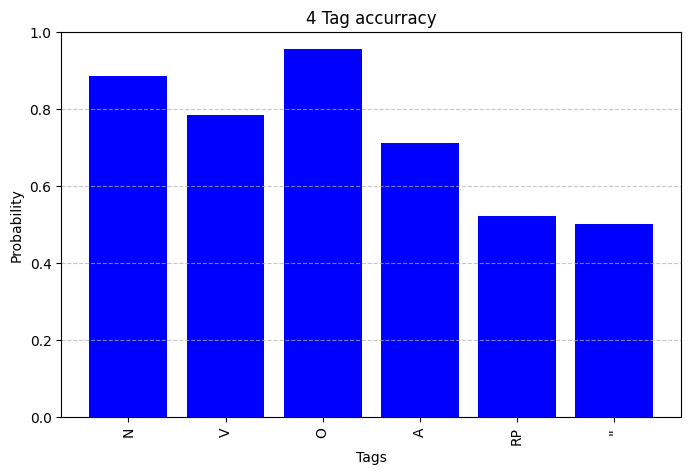

In [10]:
import matplotlib.pyplot as plt
def plot_accuracy(data,name):
    plt.figure(figsize=(8, 5))
    plt.bar(data.keys(), data.values(), color='blue')
    plt.title(name)
    plt.xlabel('Tags')
    plt.ylabel('Probability')
    plt.xticks(rotation=90)
    plt.ylim(0, 1)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

plot_accuracy(per_tag_acc_4,"4 Tag accurracy")

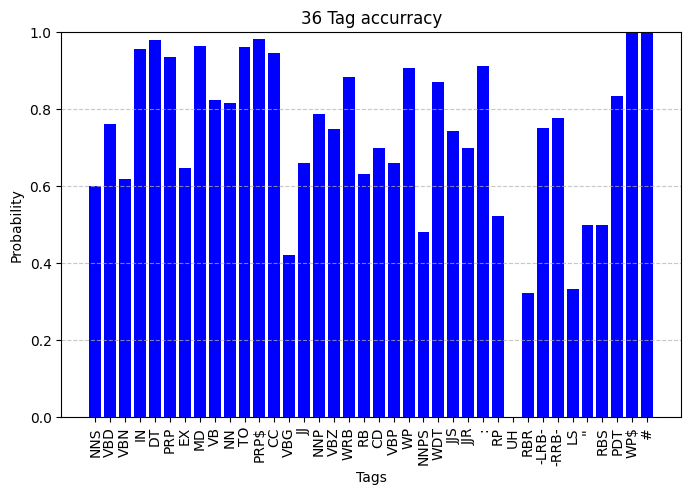

In [11]:
import matplotlib.pyplot as plt
def plot_accuracy(data,name):
    plt.figure(figsize=(8, 5))
    plt.bar(data.keys(), data.values(), color='blue')
    plt.title(name)
    plt.xlabel('Tags')
    plt.ylabel('Probability')
    plt.xticks(rotation=90)
    plt.ylim(0, 1)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

plot_accuracy(per_tag_acc_36,"36 Tag accurracy")